In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [3]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

zdim = 100

In [4]:
def build_gen(zdim):
    model = Sequential()
    model.add(Dense(256*7*7, input_dim=zdim))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

In [5]:
def build_dis(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [6]:
def build_gan(gen, dis):
    model = Sequential()
    model.add(gen)
    model.add(dis)
    return model

In [7]:
dis_v = build_dis(img_shape)
dis_v.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

In [8]:
gen_v = build_gen(zdim)
dis_v.trainable = True
gan_v = build_gan(gen_v, dis_v)
gan_v.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
losses = []
accuracies = []
iteration_checks = []

In [10]:
def train(iterations, batch_size, interval):
    
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    (Xtrain, _), (_, _) = mnist.load_data()
    Xtrain = Xtrain / 127.5 - 1.0
    Xtrain = np.expand_dims(Xtrain, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        ids = np.random.randint(0, Xtrain.shape[0], batch_size)
        imgs = Xtrain[ids]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = gen_v.predict(z)

        dloss_real = dis_v.train_on_batch(imgs, real)
        dloss_fake = dis_v.train_on_batch(gen_imgs, fake)

        dloss, accuracy = 0.5 * np.add(dloss_real, dloss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gloss = gan_v.train_on_batch(z, real)

        if (iteration+1) % interval == 0:
            losses.append((dloss, gloss))
            accuracies.append(100.0 * accuracy)
            iteration_checks.append(iteration+1)

            sys.stdout = original_stdout
            print("%d [D loss: %f , acc: %.2f] [G loss: %f]" %
                  (iteration+1, dloss, 100.0 * accuracy, gloss))
            sys.stdout = open(os.devnull, 'w')
            show_images(gen_v)


In [11]:
def show_images(gen):
    z = np.random.normal(0, 1, (16, 100))
    gen_imgs = gen.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(4, 4, figsize=(4, 4), sharey=True, sharex=True)

    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    plt.show()


1000 [D loss: 0.003449 , acc: 100.00] [G loss: 0.005727]


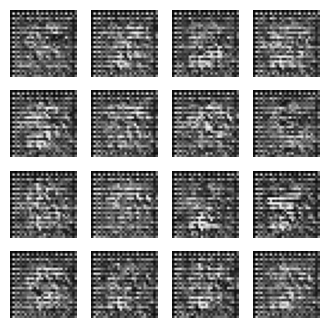

2000 [D loss: 0.018909 , acc: 100.00] [G loss: 0.023873]


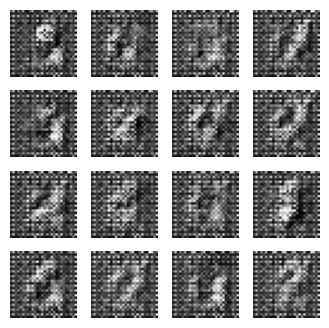

3000 [D loss: 0.045126 , acc: 100.00] [G loss: 0.035725]


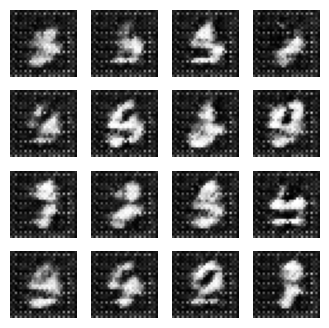

4000 [D loss: 0.005519 , acc: 100.00] [G loss: 0.019209]


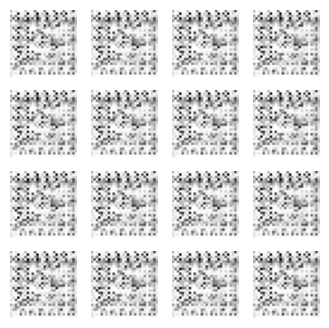

5000 [D loss: 0.035003 , acc: 100.00] [G loss: 0.096804]


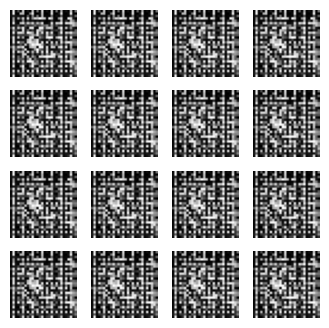

6000 [D loss: 0.018322 , acc: 100.00] [G loss: 0.061902]


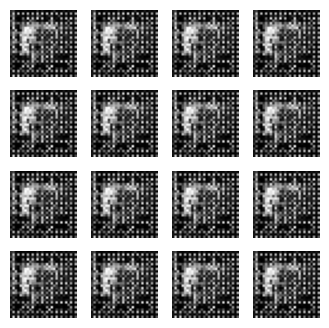

7000 [D loss: 0.035424 , acc: 100.00] [G loss: 0.071610]


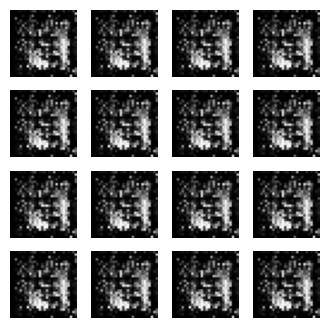

8000 [D loss: 0.110706 , acc: 99.61] [G loss: 1.899208]


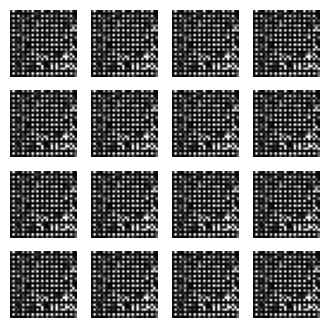

9000 [D loss: 0.054746 , acc: 99.61] [G loss: 0.158371]


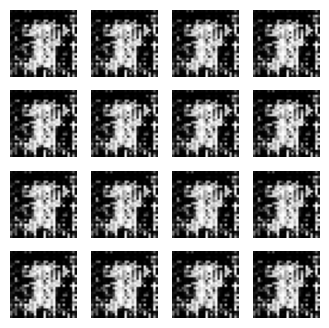

10000 [D loss: 0.002213 , acc: 100.00] [G loss: 0.012194]


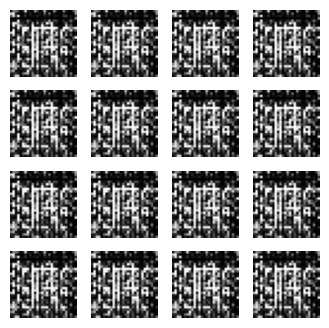

11000 [D loss: 0.032915 , acc: 100.00] [G loss: 0.103217]


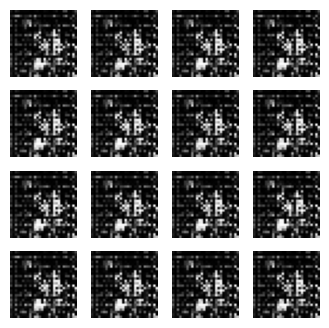

12000 [D loss: 0.449387 , acc: 64.06] [G loss: 1.864941]


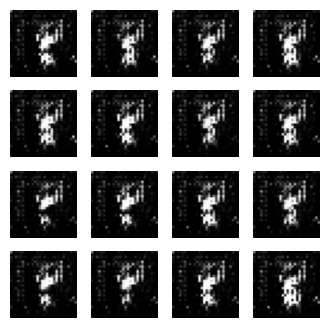

13000 [D loss: 0.340563 , acc: 83.98] [G loss: 0.919231]


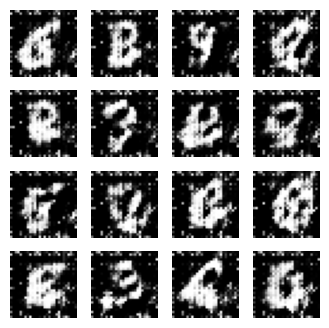

14000 [D loss: 0.047775 , acc: 100.00] [G loss: 0.167075]


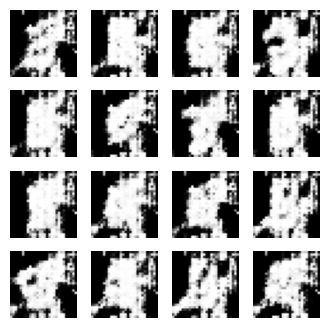

15000 [D loss: 0.011347 , acc: 100.00] [G loss: 0.046953]


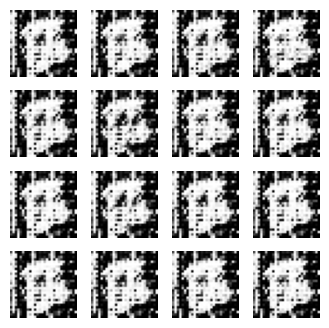

16000 [D loss: 0.012822 , acc: 99.61] [G loss: 0.028630]


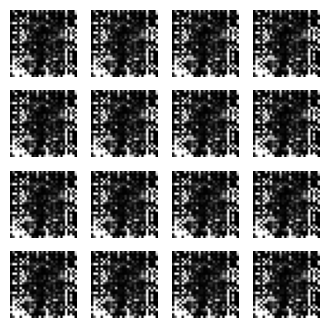

17000 [D loss: 0.028616 , acc: 99.61] [G loss: 0.128915]


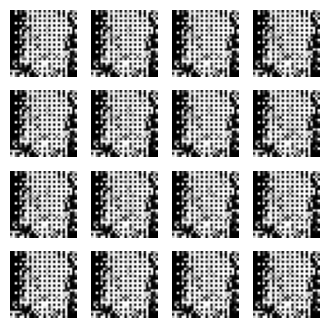

18000 [D loss: 0.010074 , acc: 100.00] [G loss: 0.038942]


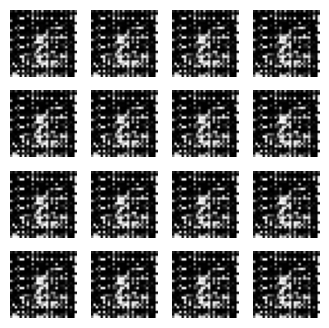

19000 [D loss: 0.015547 , acc: 100.00] [G loss: 0.060770]


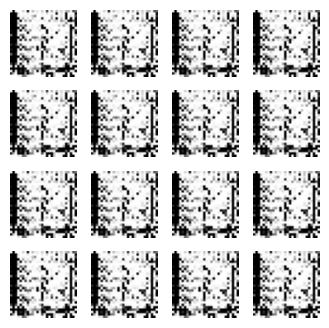

20000 [D loss: 0.961095 , acc: 47.27] [G loss: 1.567271]


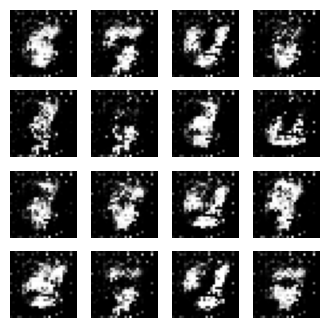

21000 [D loss: 0.863419 , acc: 47.66] [G loss: 1.389573]


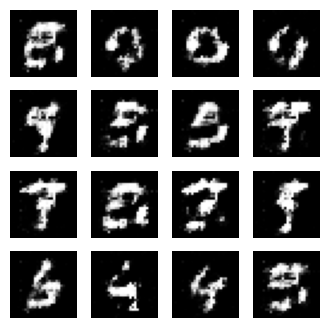

22000 [D loss: 0.418823 , acc: 60.94] [G loss: 2.928534]


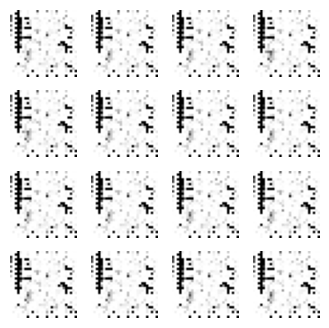

23000 [D loss: 0.857932 , acc: 50.00] [G loss: 5.182881]


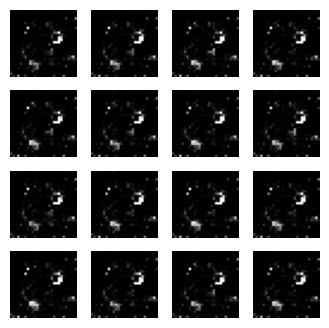

24000 [D loss: 0.022720 , acc: 100.00] [G loss: 0.104587]


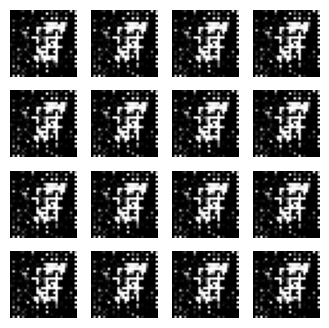

25000 [D loss: 0.757567 , acc: 53.52] [G loss: 1.604706]


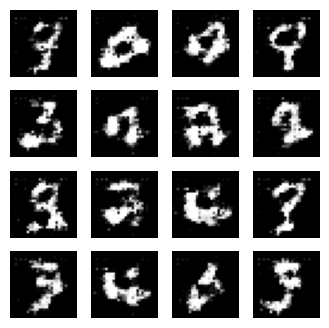

26000 [D loss: 0.225166 , acc: 92.58] [G loss: 0.408078]


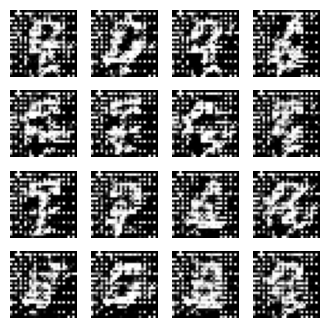

27000 [D loss: 0.027439 , acc: 100.00] [G loss: 0.060362]


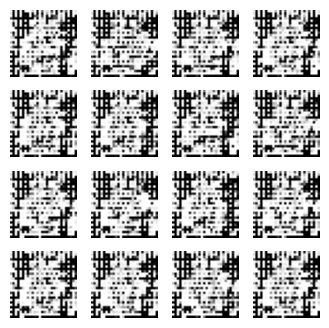

28000 [D loss: 0.128144 , acc: 99.61] [G loss: 0.386846]


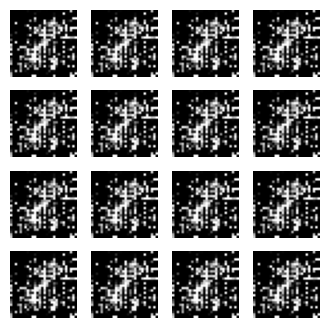

29000 [D loss: 0.341979 , acc: 75.00] [G loss: 1.537198]


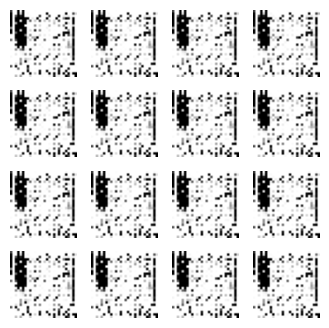

30000 [D loss: 0.327946 , acc: 85.94] [G loss: 3.395203]


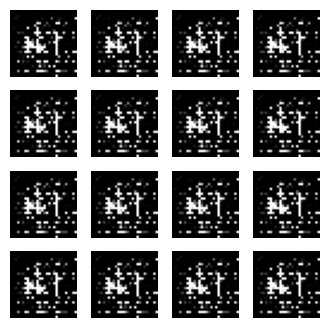

31000 [D loss: 1.004799 , acc: 50.00] [G loss: 1.644600]


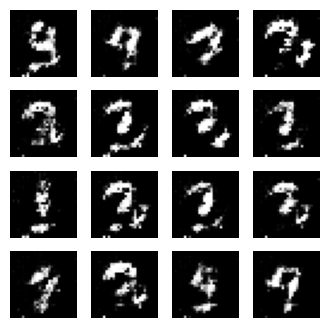

32000 [D loss: 0.046327 , acc: 99.61] [G loss: 0.171093]


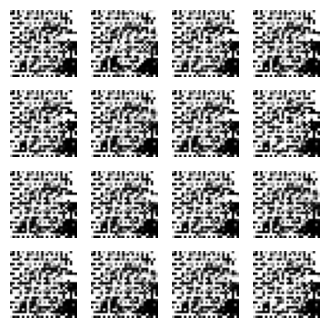

33000 [D loss: 0.156483 , acc: 99.22] [G loss: 1.380766]


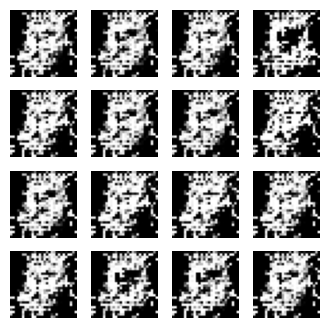

34000 [D loss: 0.009143 , acc: 100.00] [G loss: 0.040860]


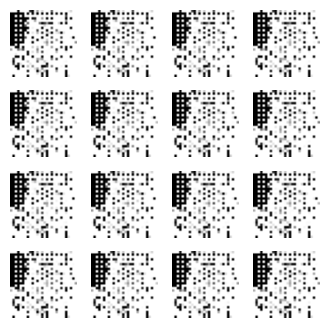

35000 [D loss: 0.005330 , acc: 100.00] [G loss: 0.025023]


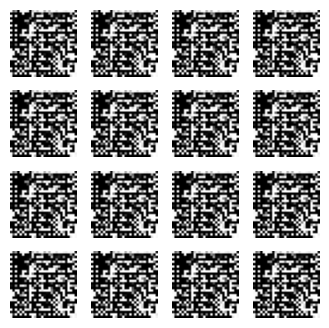

36000 [D loss: 0.010822 , acc: 100.00] [G loss: 0.004385]


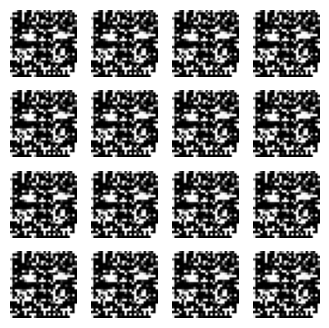

37000 [D loss: 1.012687 , acc: 50.00] [G loss: 3.128135]


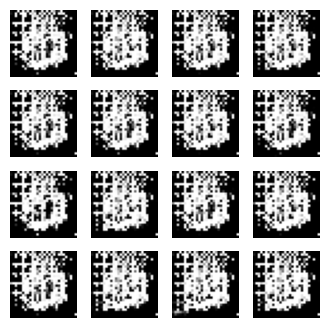

2024-02-12 14:41:49.939381: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


38000 [D loss: 0.048959 , acc: 100.00] [G loss: 1.275595]


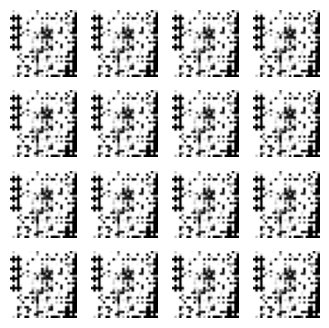

39000 [D loss: 0.776627 , acc: 54.69] [G loss: 4.236067]


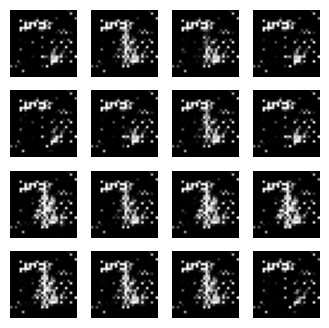

40000 [D loss: 0.995820 , acc: 50.00] [G loss: 2.028976]


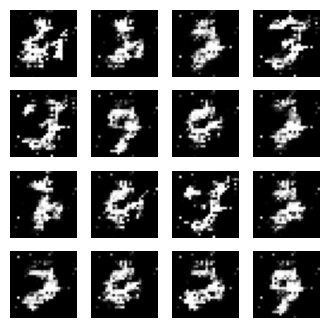

41000 [D loss: 0.011482 , acc: 100.00] [G loss: 0.061693]


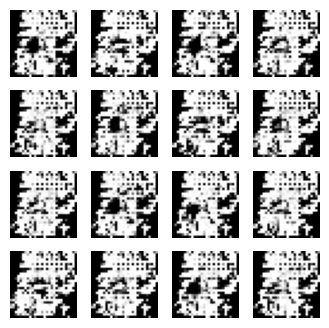

42000 [D loss: 0.032876 , acc: 100.00] [G loss: 0.167708]


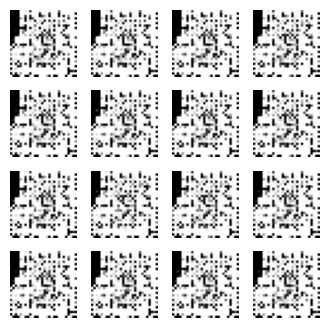

43000 [D loss: 0.496511 , acc: 53.12] [G loss: 4.292642]


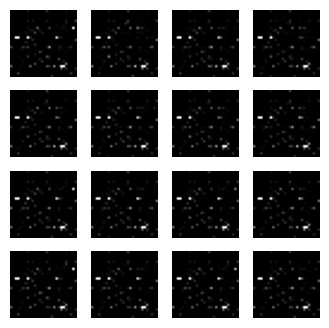

44000 [D loss: 0.161447 , acc: 99.22] [G loss: 0.657246]


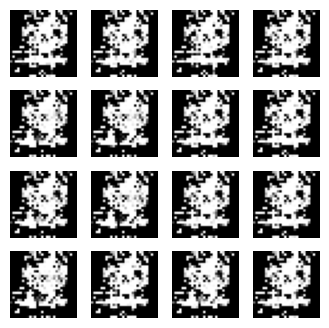

45000 [D loss: 0.033768 , acc: 99.61] [G loss: 0.072491]


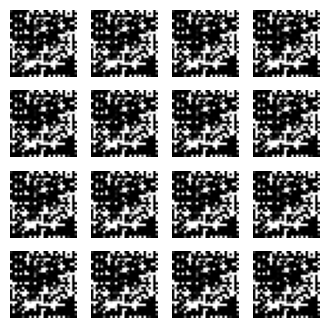

46000 [D loss: 0.901325 , acc: 62.89] [G loss: 3.622791]


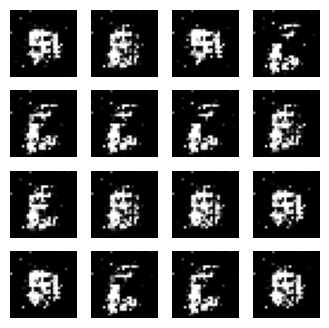

47000 [D loss: 0.544865 , acc: 64.06] [G loss: 2.734540]


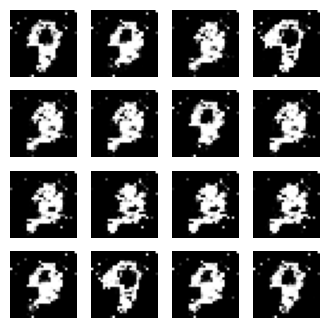

48000 [D loss: 0.245530 , acc: 92.19] [G loss: 3.735850]


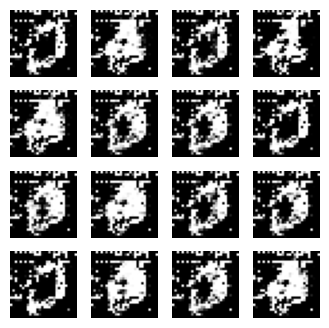

49000 [D loss: 0.301541 , acc: 84.77] [G loss: 3.271232]


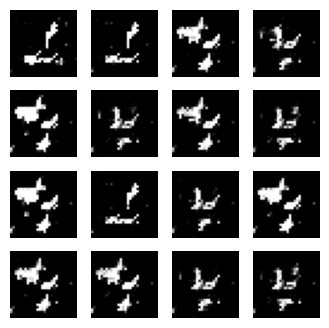

50000 [D loss: 0.008583 , acc: 100.00] [G loss: 0.024496]


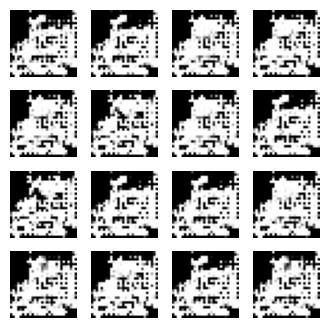

In [12]:
train(50000, 128, 1000)